##**`SPC` Experiments for Input CXR  Monitoring**


Imports

In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score
from sklearn.utils import resample

import CUSUM_detector

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2024-01-17 00:21:40.997640: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 00:21:41.018732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 00:21:41.018751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 00:21:41.018774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 00:21:41.023462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 00:21:41.023754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Num GPUs Available: 0


2024-01-17 00:21:43.632050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 00:21:43.654327: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
sns.set_style('darkgrid')
np.random.seed(2023)
random.seed(2023)

### **Computing feature similarities**
Note: Analysis is done for best feature extraction method and metrics. Here, we identifed this to be supervised VGG16 features scored by cosine similarity.

#### Let's first load the features

In [2]:
def load_csv_fileparts(csv_file, max_rows=10000):
    csv_file = Path(csv_file)
    file_parts = csv_file.parent.glob(csv_file.stem+'_*.csv')
    df = pd.read_csv(next(file_parts)).dropna()
    for f in file_parts:
        df = pd.concat([df, pd.read_csv(f)])
        if len(df) > max_rows:
            return df.iloc[:max_rows]
    return df

In [ ]:
# Replace these paths with your desired save locations
training_features_path = Path('/home/brandon.nelson/Dev/AI_monitoring/feature_methods/CXR/in_distribution_train_features.csv') # features of train set
in_dist_features_path = Path('/home/brandon.nelson/Dev/AI_monitoring/feature_methods/CXR/in_distribution_test_features.csv') #training_features_path #'_supervised_in_dist_features.npy' # pool of in-dist (CXR) images
out_dist_features_path = Path('/home/brandon.nelson/Dev/AI_monitoring/feature_methods/CXR/out_distribution_test_features.csv') #'_supervised_out_dist_features.npy' # pool of out-dist (non CXR) images; this can be pedatric dataset.

In [ ]:
# Load the features
if training_features_path.exists():
    training_features = pd.read_csv(training_features_path)
    in_dist_features = pd.read_csv(in_dist_features_path)
else:
    all_in_dist_features = load_csv_fileparts(in_dist_features_path, max_rows=10000)
    all_in_dist_features.shape

    train_pct = 0.2
    training_features = all_in_dist_features.iloc[:round(len(all_in_dist_features)*train_pct)]
    in_dist_features = all_in_dist_features.iloc[round(len(all_in_dist_features)*train_pct):]
    training_features.to_csv(training_features_path, index=False)
    in_dist_features.to_csv(in_dist_features_path, index=False)

if out_dist_features_path.exists():
    out_dist_features = pd.read_csv(out_dist_features_path)
else:
    out_dist_features = load_csv_fileparts(out_dist_features_path)
    out_dist_features.pop('Unnamed: 0')
    out_dist_features.reset_index(drop=True).to_csv(out_dist_features_path, index=False)

In dist refers to in distribution testing fes whereas the retraining features are d to calculate the in control limits of

In [3]:
training_features.shape, in_dist_features.shape, out_dist_features.shape

NameError: name 'training_features' is not defined

In [ ]:
training_features.head()

In [ ]:
in_dist_features.head()

In [ ]:
out_dist_features.head()

## Now Look a the images...

In [ ]:
in_dist_features['in_dist'] = True
out_dist_features['in_dist'] = False
training_features['in_dist'] = True

training_features['train'] = True
in_dist_features['train'] = False
out_dist_features['train'] = False

features = pd.concat([training_features, in_dist_features, out_dist_features])
features

In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as keras_image

def load_img(img_path):
    img = keras_image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
    img_array = keras_image.img_to_array(img)
    # img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    # img_array = preprocess_input(img_array)
    return img_array

In [ ]:
def show_array(rows):
    im_array = [load_img(f) for f in rows['filename']]

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(im_array[i]/255), cmap=plt.cm.binary)
        label = 'adult' if rows['in_dist'].to_list()[i] else 'ped'
        plt.xlabel(f'in distribution: {label}')
    plt.show()

show_array(features[(features['in_dist'] == True) & (features['train'] == True)].sample(30))

In [ ]:
show_array(features[(features['in_dist'] == True) & (features['train'] == False)].sample(30))

In [ ]:
show_array(features[(features['in_dist'] == False) & (features['train'] == False)].sample(30))

In [ ]:
training_features.pop('train')
in_dist_features.pop('train')
out_dist_features.pop('train')

training_features.pop('in_dist')
in_dist_features.pop('in_dist')
out_dist_features.pop('in_dist')

in_dist_features.pop('filename')
in_dist_features = in_dist_features.to_numpy()
in_dist_features

training_features.pop('filename')
training_features = training_features.to_numpy()

out_dist_features.pop('filename')
out_dist_features = out_dist_features.to_numpy()

In [ ]:
training_features, in_dist_features, out_dist_features, 

#### Visualize the features

In [ ]:
# Function to perform PCA and plot
def plot_pca(features, title, ax, max_samples=3000):
    if features.shape[0] > max_samples: features = features[:max_samples]
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each dataset
plot_pca(training_features, 'Training Features', axes[0])
plot_pca(in_dist_features, 'In-Dist Features', axes[1])
plot_pca(out_dist_features, 'Out-Dist Features', axes[2])

plt.tight_layout()
plt.show()


In [ ]:
    # pca = PCA(n_components=2)
    # pca_result = pca.fit_transform(features)

In [ ]:
features.iloc[:, 1:-2]

: 

In [ ]:
in_dist_features.shape, out_dist_features.shape

((8000, 25088), (5015, 25088))

## OOD Metric Computation
Compute the cosine similarity or mahalanobis distance for the features based on the functions below

In [63]:
import numpy as np
from scipy.spatial import distance
from numpy.linalg import pinv

def compute_similarity(tr_features, tt_features, similarity_type='cosine'):
    """
    Compute similarities between training and testing features based on the specified type.

    Parameters:
    - tr_features (array): Training feature vectors.
    - tt_features (array): Testing feature vectors.
    - similarity_type (str): Type of similarity to compute ('cosine' or 'mahalanobis').

    Returns:
    - dict: Contains computed similarities and basic statistics.
    """

    def compute_cosine_similarity(tr_features_, tt_features_):
        centroid = np.mean(tr_features_, axis=0)
        return [1 - distance.cosine(feature, centroid) for feature in tt_features_]

    def compute_mahalanobis_similarity(tr_features_, tt_features_):
        covariance_matrix = np.cov(tr_features_, rowvar=False)
        covariance_matrix_inv = pinv(covariance_matrix)
        centroid = np.mean(tr_features_, axis=0)
        return [distance.mahalanobis(feature, centroid, covariance_matrix_inv) for feature in tt_features_]

    # Compute similarities
    if similarity_type == 'cosine':
        similarities = compute_cosine_similarity(tr_features, tt_features)
    elif similarity_type == 'mahalanobis':
        similarities = compute_mahalanobis_similarity(tr_features, tt_features)
    else:
        raise ValueError("Invalid similarity type. Choose 'cosine' or 'mahalanobis'.")

    # Compute statistics
    mean_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    median_similarity = np.median(similarities)
    mad_similarity = np.median(np.abs(similarities - median_similarity))
    percentile_95 = np.percentile(similarities, 95)
    percentile_99 = np.percentile(similarities, 99)
    range_similarity = np.ptp(similarities)
    iqr_similarity = np.percentile(similarities, 75) - np.percentile(similarities, 25)

    return {
        'similarities': similarities,
        'mean': mean_similarity,
        'std': std_similarity,
        'median': median_similarity,
        'mad': mad_similarity,
        'percentile_95': percentile_95,
        'percentile_99': percentile_99,
        'range': range_similarity,
        'iqr': iqr_similarity
    }

In [ ]:
# Example usage: Cosine OOD
# Assuming train_features, test_in_dist_features, and test_out_dist_features are defined
similarity_type = 'mahalanobis' #  "cosine"
cosine_train_similarities_VGG16 = compute_similarity(training_features, training_features, similarity_type)
cosine_train_similarities_VGG16_values = cosine_train_similarities_VGG16['similarities']
cosine_mean_train_VGG16 = cosine_train_similarities_VGG16["mean"]
cosine_std_train_VGG16 = cosine_train_similarities_VGG16["std"]


# Computing the 3-sigma upper and lower control limits
nsigma = 1 #from 3
cosine_3UCL_train_upper_VGG16 = cosine_mean_train_VGG16 + nsigma * cosine_std_train_VGG16
cosine_3LCL_train_lower_VGG16 = cosine_mean_train_VGG16 - nsigma * cosine_std_train_VGG16

# In-dist pool OOD metric
cosine_in_dist_similarities_VGG16 = compute_similarity(training_features, in_dist_features, "cosine")
cosine_in_dist_similarities_VGG16_values = cosine_in_dist_similarities_VGG16['similarities']
cosine_in_dist_similarities_VGG16_mean = cosine_in_dist_similarities_VGG16["mean"]
cosine_in_dist_similarities_VGG16_std = cosine_in_dist_similarities_VGG16["std"]

# Out-dist pool OOD metric
cosine_out_dist_similarities_VGG16 = compute_similarity(training_features, out_dist_features, "cosine")
cosine_out_dist_similarities_VGG16_values = cosine_out_dist_similarities_VGG16['similarities']
cosine_out_dist_similarities_VGG16_mean = cosine_out_dist_similarities_VGG16["mean"]
cosine_out_dist_similarities_VGG16_std = cosine_out_dist_similarities_VGG16["std"]


print(f"{similarity_type} - Mean train: {} | STD train: {}".format(cosine_mean_train_VGG16, cosine_std_train_VGG16))
print(f"{similarity_type} - MEAN in-dist: {} | MEAN out-dist: {}".format(cosine_in_dist_similarities_VGG16_mean, cosine_in_dist_similarities_VGG16_std))
print(f"{similarity_type} - STD out-dist: {} | STD out-dist: {}".format(cosine_out_dist_similarities_VGG16_mean, cosine_out_dist_similarities_VGG16_std))


Cosine - Mean train: 0.608255452520578 | STD train: 0.07550376402999111
Cosine - MEAN in-dist: 0.609553074924579 | MEAN out-dist: 0.0766886395265171
Cosine - STD out-dist: 0.47979643513121706 | STD out-dist: 0.05021999545318426


## Plot the OOD metrics for train, in-dist pool, and out-dist pool

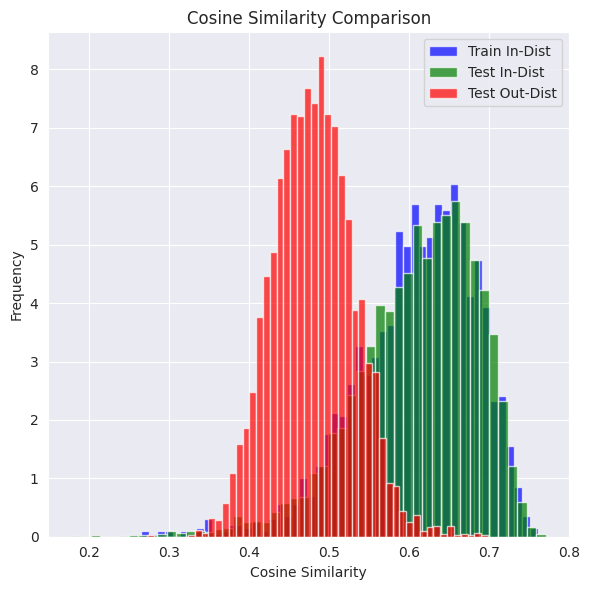

In [ ]:
# Create histograms
plt.figure(figsize=(6, 6))

# Training Features Histogram
plt.subplot(1, 1, 1)
plt.hist(cosine_train_similarities_VGG16_values, bins=50, color='blue', alpha=0.7, label='Train In-Dist', density=True)
# plt.title('Train Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# In-Dist Features Histogram
plt.subplot(1, 1, 1)
plt.hist(cosine_in_dist_similarities_VGG16_values, bins=50, color='green', alpha=0.7, label='Test In-Dist', density=True)
# plt.title('In-Dist Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Out-Dist Features Histogram
plt.subplot(1, 1, 1)
plt.hist(cosine_out_dist_similarities_VGG16_values, bins=50, color='red', alpha=0.7, label='Test Out-Dist', density=True)
plt.title('Cosine Similarity Comparison')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


## Create 3-sigma SPC chart for randomly selected images
Randomly pick 50 points from in-distribution and out-of-distribution cosine values, and plot them based on the control limits of train features

In [ ]:
# Randomly pick 50 points from in-distribution and out-of-distribution cosine similarities
in_dist_samples = np.random.choice(cosine_in_dist_similarities_VGG16_values, 50, replace=False)
out_dist_samples = np.random.choice(cosine_out_dist_similarities_VGG16_values, 50, replace=False)

# Combine and shuffle these 100 points
combined_samples = np.concatenate((in_dist_samples, out_dist_samples))
# Also, create a label array to track InD (0) and OOD (1) points
labels = np.array([0]*50 + [1]*50)
# Shuffle both arrays in unison
shuffled_indices = np.random.permutation(np.arange(100))
combined_samples = combined_samples[shuffled_indices]
labels = labels[shuffled_indices]
#np.random.shuffle(combined_samples)
print(combined_samples)

# Identify points as in or out of distribution based on control limits
ood_predictions = [1 if val < cosine_3LCL_train_lower_VGG16 else 0 for val in combined_samples]

[0.60037404 0.4989101  0.39195219 0.5027647  0.36355297 0.4554572
 0.6324934  0.57593796 0.4828229  0.67711602 0.5597877  0.46130147
 0.69108009 0.50812525 0.54233403 0.63335312 0.41628536 0.61549884
 0.6409     0.51702113 0.59420915 0.59737635 0.52436837 0.53067608
 0.4334945  0.49936021 0.62495951 0.48153101 0.51848021 0.6162242
 0.47201946 0.74960682 0.36717227 0.4992779  0.40960703 0.62371076
 0.53621077 0.4949348  0.50204921 0.52105153 0.47111666 0.48978211
 0.42788948 0.61838664 0.46554876 0.4992915  0.66371768 0.55624526
 0.67901288 0.54893701 0.56059709 0.53271229 0.5197918  0.48345324
 0.3390817  0.47349932 0.55673861 0.68525258 0.41306765 0.45133087
 0.52523359 0.6392321  0.66563854 0.56990977 0.39864629 0.59955873
 0.66465831 0.48974829 0.55887874 0.66387203 0.7113553  0.4917837
 0.52174655 0.62454977 0.46836318 0.60738676 0.55090584 0.45283809
 0.56719146 0.65392734 0.37103718 0.53936268 0.55763532 0.42451331
 0.494578   0.59212564 0.66406127 0.71352986 0.54343607 0.3632144

#### Now, plot the chart (one image/point at a time)

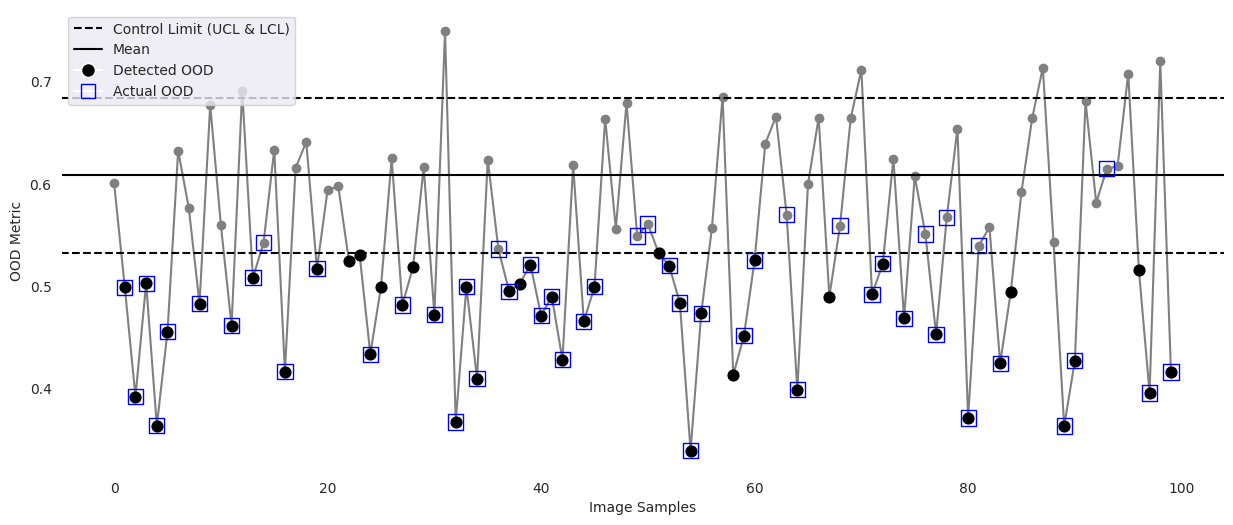

In [ ]:
# Assuming the following are defined:
# combined_samples - contains the mixed in-distribution and out-of-distribution points
# ood_predictions - flags for points detected as out-of-distribution based on control limits
# labels - actual labels indicating whether a point is in-distribution (0) or out-of-distribution (1)
# cosine_3UCL_train_upper, cosine_3LCL_train_lower - control limits
# cosine_mean_train - mean cosine similarity for the training set

# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(combined_samples, marker='o', linestyle='-', color='grey', zorder=1)

# Plot control limits and mean
ax.axhline(np.clip(cosine_3UCL_train_upper_VGG16, a_min=0.0, a_max=1.0), color='k', linestyle='--', label='Control Limit (UCL & LCL)')
ax.axhline(np.clip(cosine_3LCL_train_lower_VGG16, a_min=0.0, a_max=1.0), color='k', linestyle='--')
ax.axhline(cosine_mean_train_VGG16, color='k', linestyle='-', label='Mean')

# Highlight points detected as out-of-distribution with black stars
for i, val in enumerate(combined_samples):
    if ood_predictions[i] == 1:
        ax.scatter(i, val, color='black', marker='o', s=60, zorder=2)

# Circle actual out-of-distribution points with blue circles
for i, val in enumerate(combined_samples):
    if labels[i] == 1:
        ax.scatter(i, val, marker='s', facecolors='none', edgecolors='blue', s=120, zorder=3)

# Set chart properties
ax.set_facecolor('white')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Update the legend
legend_elements = [plt.Line2D([0], [0], color='k', linestyle='--', label='Control Limit (UCL & LCL)'),
                   plt.Line2D([0], [0], color='k', linestyle='-', label='Mean'),
                   plt.Line2D([0], [0], marker='o', color='w', label='Detected OOD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Actual OOD', markerfacecolor='none', markeredgecolor='blue', markersize=10)]
ax.legend(handles=legend_elements)

# Set chart properties (adding the axis labels here)
ax.set_xlabel('Image Samples')  # X-axis label
ax.set_ylabel('OOD Metric')    # Y-axis label
ax.set_facecolor('white')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# Show the plot
plt.show()


### Now, we compute the perfomance of SPC-based OOD for all points in both in-dist and out-dist pools.

In [ ]:
# Combine the cosine similarity scores and their corresponding labels
combined_scores = np.concatenate([cosine_in_dist_similarities_VGG16_values, cosine_out_dist_similarities_VGG16_values])
# Label: 1 for out-of-distribution, 0 for in-distribution
combined_labels = np.concatenate([np.zeros(len(cosine_in_dist_similarities_VGG16_values)), np.ones(len(cosine_out_dist_similarities_VGG16_values))])

# Apply the rule to flag points
ood_predictions = np.array([1 if val < cosine_3LCL_train_lower_VGG16 else 0 for val in combined_scores])

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    sensitivity = recall_score(y_true, y_pred)  # Same as recall
    specificity = recall_score(y_true, y_pred, pos_label=0)
    accuracy = accuracy_score(y_true, y_pred)
    return sensitivity, specificity, accuracy

# Compute initial metrics
initial_sensitivity, initial_specificity, initial_accuracy = compute_metrics(combined_labels, ood_predictions)

# Bootstrapping for confidence intervals
n_iterations = 1000
n_size = int(len(combined_labels) * 0.5)  # 50% sample size
bootstrapped_metrics = []

for _ in range(n_iterations):
    # Prepare bootstrap sample
    indices = resample(np.arange(len(combined_labels)), n_samples=n_size)
    boot_labels = combined_labels[indices]
    boot_predictions = ood_predictions[indices]

    # Compute metrics
    metrics = compute_metrics(boot_labels, boot_predictions)
    bootstrapped_metrics.append(metrics)

# Convert to numpy array for easy percentile computation
bootstrapped_metrics = np.array(bootstrapped_metrics)

# Compute 95% confidence intervals
lower_p = 2.5
upper_p = 97.5
sensitivity_conf = np.percentile(bootstrapped_metrics[:, 0], [lower_p, upper_p])
specificity_conf = np.percentile(bootstrapped_metrics[:, 1], [lower_p, upper_p])
accuracy_conf = np.percentile(bootstrapped_metrics[:, 2], [lower_p, upper_p])
print("Supervised features (initial_accuracy)", initial_accuracy)
print("Supervised features (accuracy_conf)", accuracy_conf)

print("Supervised features (initial_sensitivity)", initial_sensitivity)
print("Supervised features (sensitivity_conf)", sensitivity_conf)

print("Supervised features (initial_specificity)", initial_specificity)
print("Supervised features (specificity_conf)", specificity_conf)

NameError: name 'np' is not defined

## **Simulated Monitoring Scenario**

"""Time simulation
Days 0-30: 0-3% OOD rate
Days 30-60: 4-6% OOD rate
"""


In [ ]:
# Define the number of days and images per day
total_days = 60
images_per_day = 100

In [ ]:
# Create an empty list to store daily data
import numpy as np
all_data = []
percentages_out_dist = []

# Function to select data for each day
def select_daily_data(in_dist_data, out_dist_data, out_dist_percent, day_data_count):
    out_dist_count = int(day_data_count * out_dist_percent / 100)
    in_dist_count = day_data_count - out_dist_count

    # Randomly select out-of-distribution and in-distribution data
    daily_out_dist_data = np.random.choice(out_dist_data, out_dist_count, replace=False)
    daily_in_dist_data = np.random.choice(in_dist_data, in_dist_count, replace=False)

    # Combine and return the daily data
    return np.concatenate([daily_out_dist_data, daily_in_dist_data])

 # Simulate data for each day
for day in range(1, total_days + 1):
    if day <= 30:
        percent_out_dist = (0, 3)
    else:
        percent_out_dist = (4,6)

    # If range is given for percent, choose randomly
    if type(percent_out_dist) == tuple:
        p = np.random.uniform(low=percent_out_dist[0], high=percent_out_dist[1])
    else:
        p = percent_out_dist
    percentages_out_dist.append(p)

    daily_data = select_daily_data(
        cosine_in_dist_similarities_VGG16_values,
        cosine_out_dist_similarities_VGG16_values,
        p,
        images_per_day
    )
    all_data.append(daily_data)


# Combine all daily data for CUSUM analysis
avg_cusum_data = np.concatenate(all_data)
daily_averages = [np.mean(day) for day in all_data]
CUSUM_data_average_day = np.array(daily_averages)

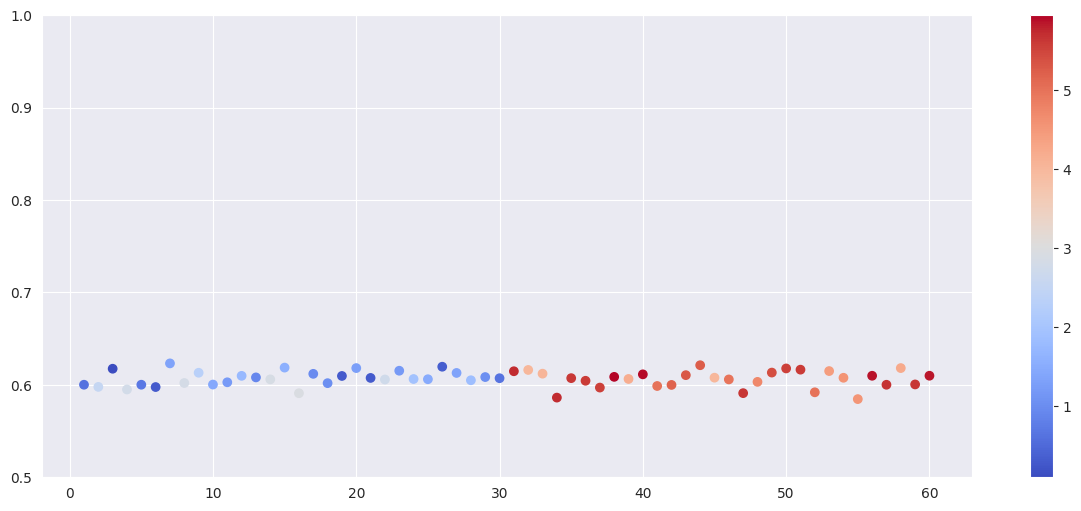

In [ ]:
"""Plotting day-averaged cosine distance"""
plt.figure(figsize=(15, 6))
sc = plt.scatter(range(1, total_days + 1), daily_averages, c=percentages_out_dist, cmap='coolwarm')
# plt.colorbar(sc, label='Out-of-Distribution Percentage (%)')
plt.colorbar(sc)
# plt.title('Day-Averaged Cosine Similarity')
# plt.xlabel('Day')
# plt.ylabel('Average Cosine Distance')
plt.ylim([0.5, 1])
plt.grid(True)
plt.savefig("../figs/ood_simulation.png")
plt.show()

In [ ]:
len(cosine_in_dist_similarities_VGG16_values), len(cosine_out_dist_similarities_VGG16_values)

(8000, 5015)

In [ ]:
len(cosine_out_dist_similarities_VGG16_values)/len(cosine_in_dist_similarities_VGG16_values)*total_days 

37.6125

In [ ]:
all_data.shape

AttributeError: 'list' object has no attribute 'shape'

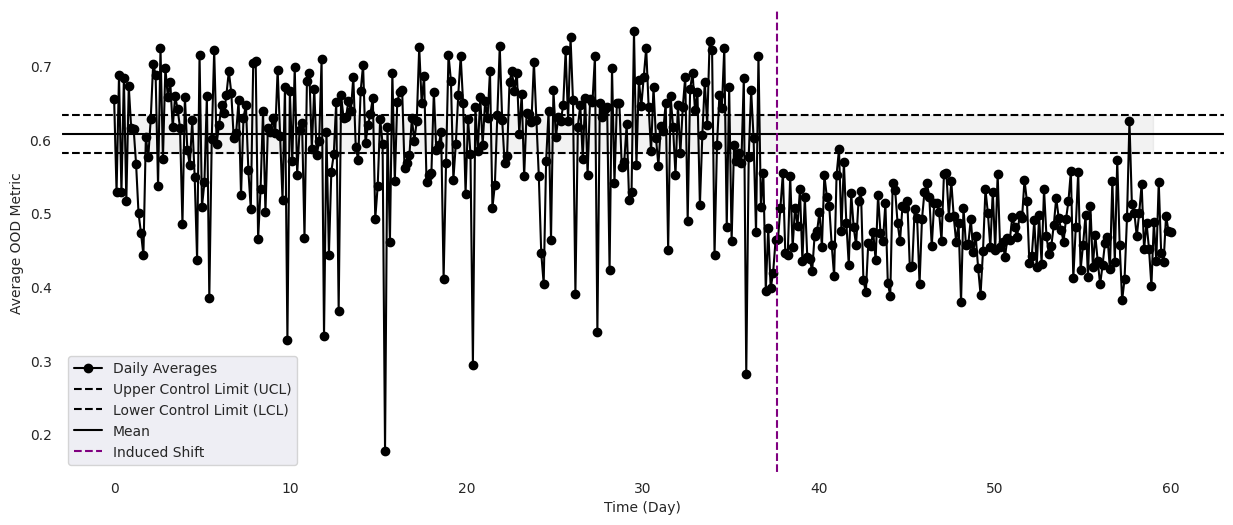

In [ ]:
"""Three-sigma SPC chart for per-day averages"""
# Define the control limits using the three-sigma rule
mean = np.mean(daily_averages[:30])
upper_control_limit = np.mean(daily_averages[:30]) + 3 * np.std(daily_averages[:30])
lower_control_limit = np.mean(daily_averages[:30]) - 3 * np.std(daily_averages[:30])



shift_start_day = len(cosine_out_dist_similarities_VGG16_values)/len(cosine_in_dist_similarities_VGG16_values)*total_days 
scores_for_plotting = combined_scores[::30]
days = np.linspace(0, total_days, len(scores_for_plotting))


# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(days, scores_for_plotting, marker='o', linestyle='-', color='k', label='Daily Averages')  # Black color for plot



# Plot control limits and mean
ax.axhline(upper_control_limit, color='k', linestyle='--', label='Upper Control Limit (UCL)')  # Black color for UCL
ax.axhline(lower_control_limit, color='k', linestyle='--', label='Lower Control Limit (LCL)')  # Black color for LCL
ax.axhline(mean, color='k', linestyle='-', label='Mean')  # Black color for mean
plt.fill_between(range(len(daily_averages)), \
                    np.clip(lower_control_limit, a_min=0.0, a_max=1.0), \
                    np.clip(upper_control_limit, a_min=0.0, a_max=1.0), \
                    color='grey', alpha=0.1)

# Highlight points outside of control limits with pink circle around them
for i, val in enumerate(daily_averages):
  if val < lower_control_limit:
    ax.scatter(i, val, color='darkgrey', marker='*', s=150)  # Dark grey stars for out-of-control points
    ax.scatter(i, val, facecolors='none', edgecolors='grey', marker='o', s=250)  # Grey circle around out-of-control points


# Indicate the first shift point
ax.axvline(x=shift_start_day, color='purple', linestyle='--', label='Induced Shift')  # Purple line for shift start

ax.set_facecolor('white')  # White background
ax.set_xlabel('Time (Day)')
ax.set_ylabel('Average OOD Metric ')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Lighter grid lines for better visibility

# Show the plot
# plt.show()


# Show the plot
plt.savefig("../figs/batched_3sigma_ctr_cosine.png")



In [ ]:
"""CUSUM"""
# Specify the control parameters and the threshold
pre_change_days = 30  # Number of days the process is in-control
total_days = 60  # Total number of days in the dataset
control_limit = 4  # Multiplier for control limit
detector = CUSUM_detector.CUSUMChangeDetector(pre_change_days, total_days)

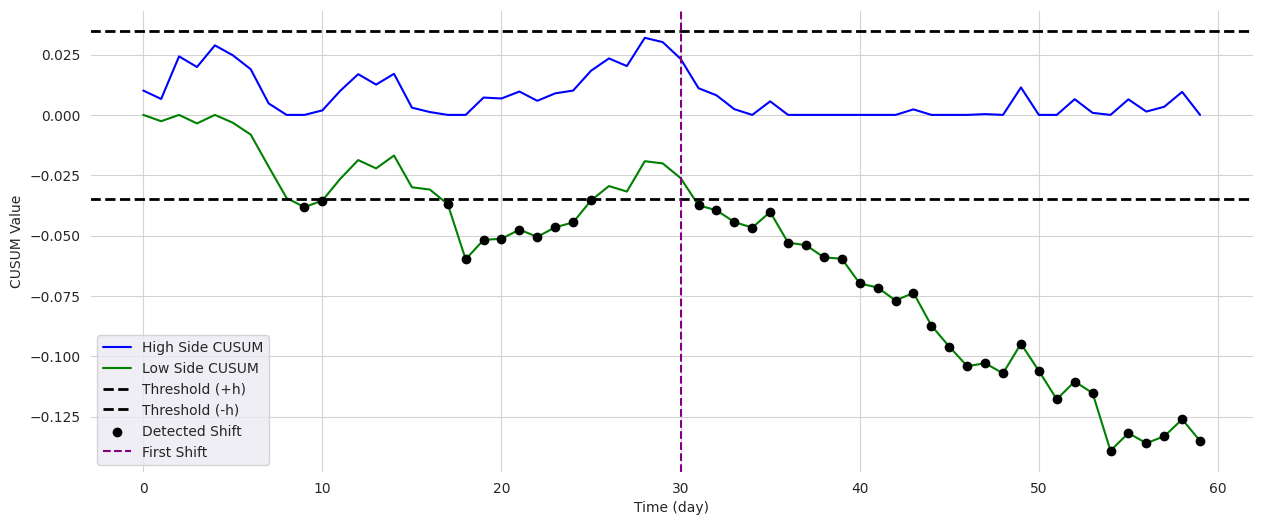

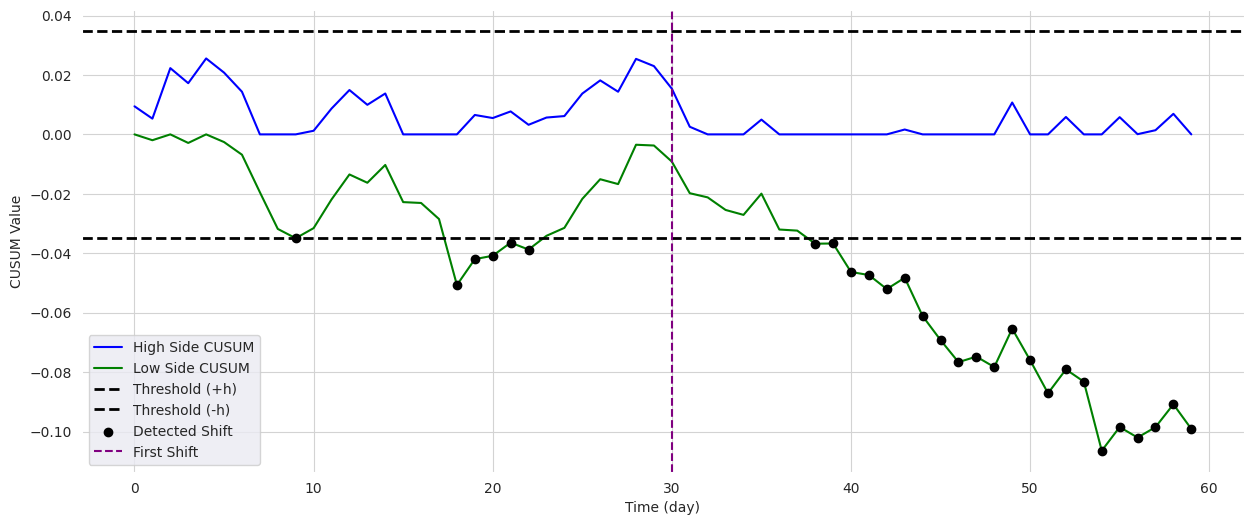

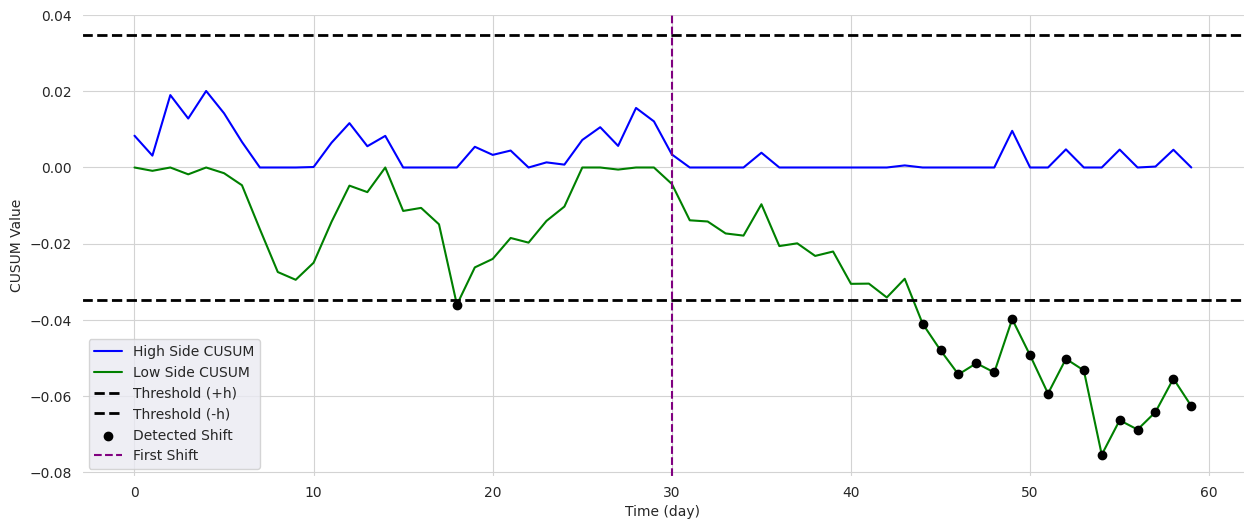

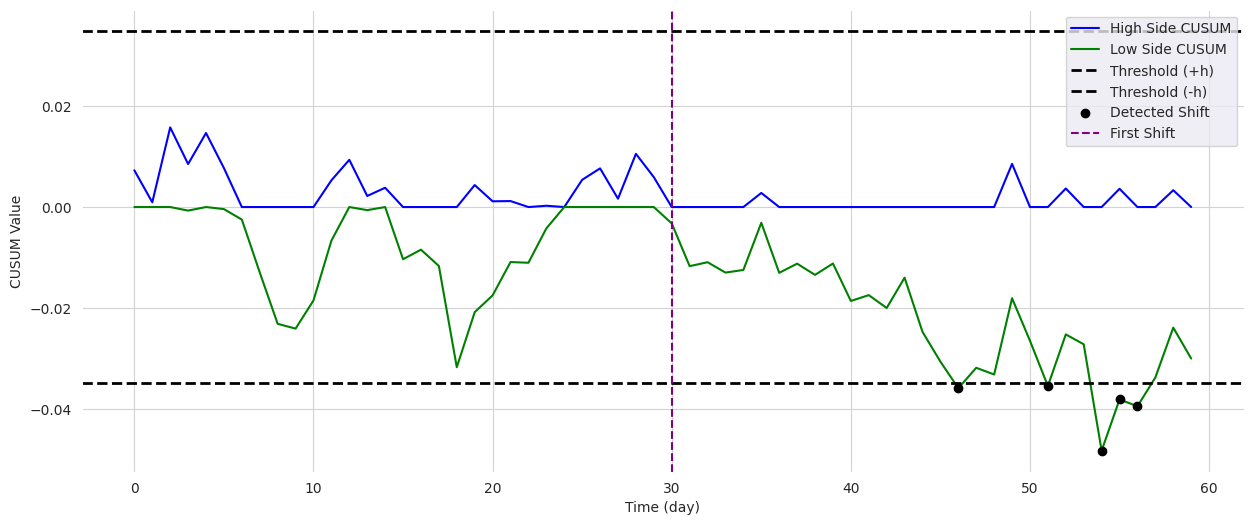

/home/brandon.nelson/miniconda3/envs/ai_monitor_vgg/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon.nelson/miniconda3/envs/ai_monitor_vgg/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


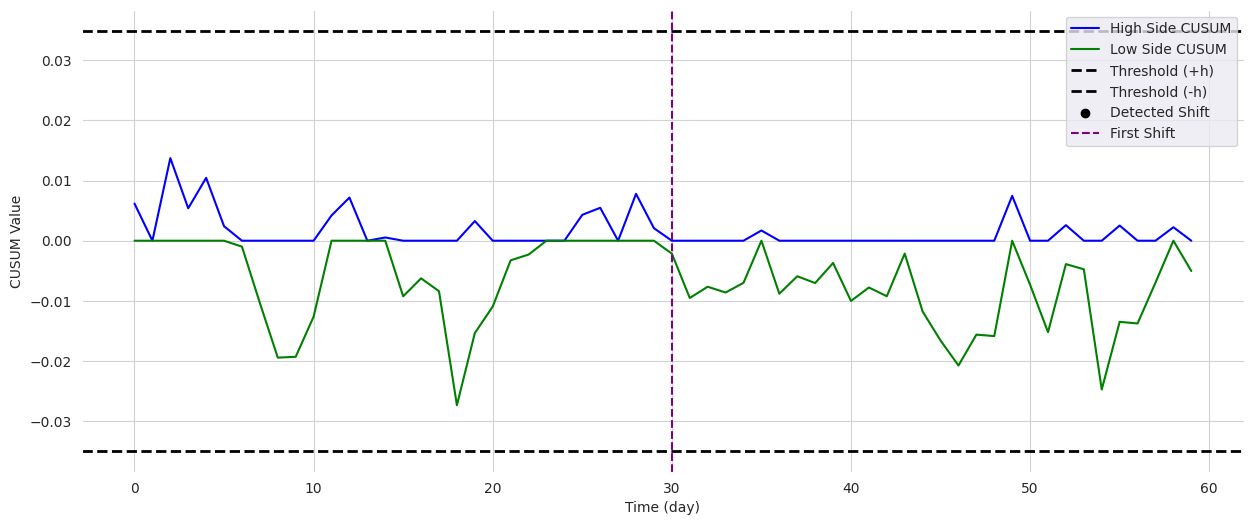

/home/brandon.nelson/miniconda3/envs/ai_monitor_vgg/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon.nelson/miniconda3/envs/ai_monitor_vgg/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
ks = [0.1, 0.25, 0.5, 0.75, 1.0]
for k in ks:
    detector.changeDetection(CUSUM_data_average_day, pre_change_days, total_days, control_limit, k, save_plot=False)


 k value  Threshold  False Positives  True Positives  Average Detection Delay     MTBFA  False Alarm Rate
    0.10        4.0             11.0             1.0                      1.0 18.909091          0.052885
    0.25        4.0              6.0             1.0                      8.0 18.166667          0.055046
    0.50        4.0              1.0             1.0                     14.0 18.000000          0.055556
    0.75        4.0              0.0             1.0                     16.0       NaN               NaN
    1.00        4.0              0.0             0.0                      NaN       NaN               NaN


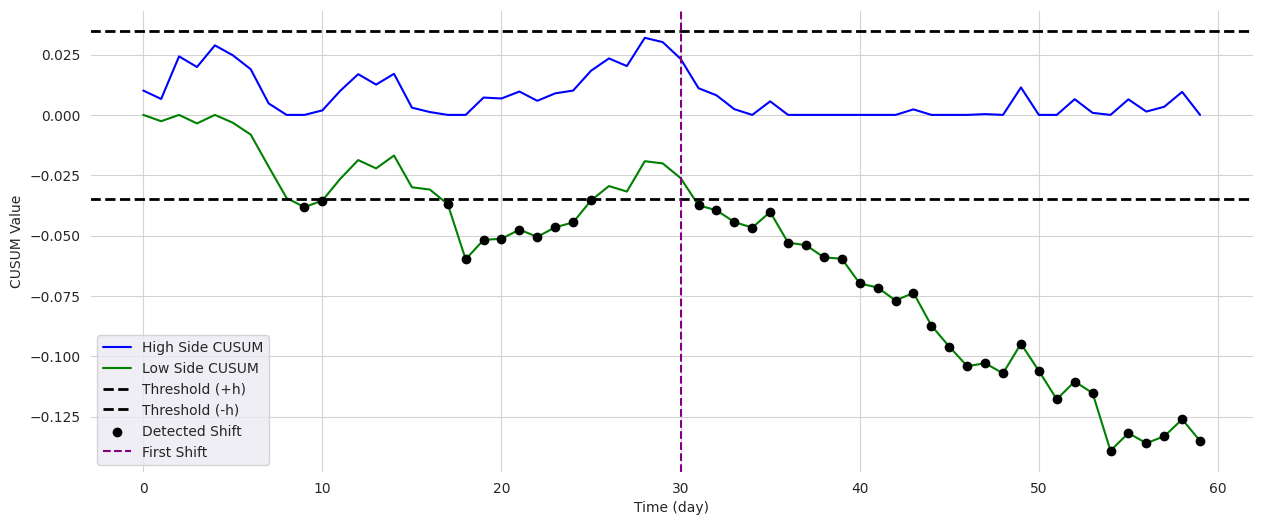

In [ ]:
# Choose best k
print(detector.summary())
# Save CUSUM for best k
detector.changeDetection(CUSUM_data_average_day, pre_change_days, total_days, control_limit, 0.10, save_plot=True)